<font color='blue'> **a01b - Freyberg (1988) - Steady State** </font> <font color='red'> **Loading from (a)** </font> 

In [1]:
import numpy as np ; import matplotlib.pyplot as plt ; import pandas as pd   ; import flopy ; from flopy.plot import styles;  from pathlib import Path; import os 

REF1 = Path("./data/Freyberg")  ; REF1=Path("_R/folder_01a")  ; TA = Path("_R/folder_01b"); TA.mkdir(exist_ok=True)  ; ID = "Freyberg"

sim = flopy.mf6.MFSimulation.load(sim_ws = REF1, verbosity_level=0)    ; sim.set_sim_path(TA) ; 
gwf = sim.get_model(ID)   ; gwf.remove_package("wel") ; modelgrid = gwf.modelgrid 

x = modelgrid.xoffset + np.random.rand(10)*4000 ; y=modelgrid.yoffset + np.random.rand(10) * 10000  ;q=np.random.rand(10) * -0.02 ; pdata = []
for ix, xc in enumerate(x):
    i, j = modelgrid.intersect(xc, y[ix], forgive=True)
    if not np.isnan(i) and not np.isnan(j):
        if modelgrid.idomain[0, i, j]:  pdata.append([(0, i, j), q[ix]])
gwf.remove_package("wel_0")  ; stress_period_data = {0: pdata} ; nouter=1000 ;ninner=25 ;hclose=1e-3 ;rclose=1e-1
flopy.mf6.modflow.ModflowGwfwel(gwf, stress_period_data=stress_period_data, pname="WEL-1")           
flopy.mf6.ModflowIms     (sim,linear_acceleration="BICGSTAB",outer_maximum=nouter,outer_dvclose=hclose * 10.0,inner_maximum=ninner,
                          inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
sim.write_simulation()  ; sim.run_simulation(silent=True) 

(False, [])

(1, 40, 20)


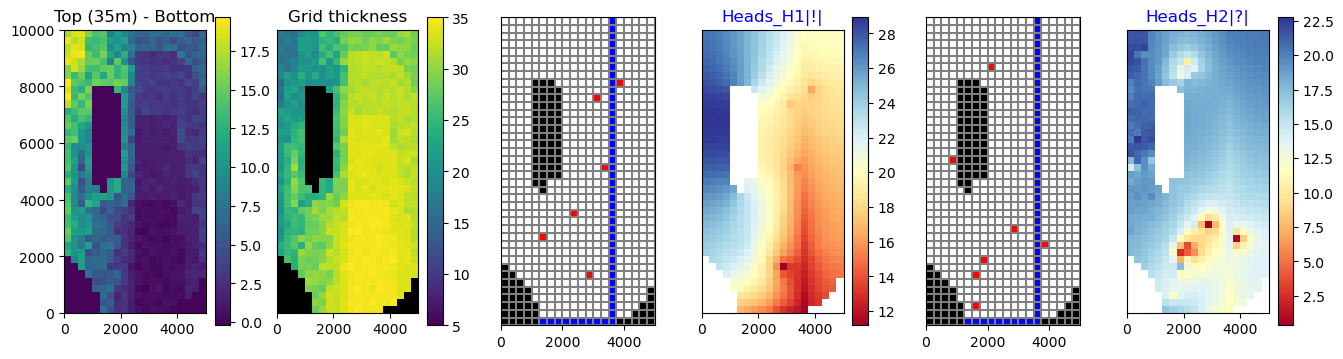

In [2]:
sim = flopy.mf6.MFSimulation.load(sim_ws = REF1, verbosity_level=0)  ; gwf2 = sim.get_model(ID)   ; head2 = gwf2.output.head().get_alldata()[0] 
ref_data=Path("./data/Freyberg") ; bottom = np.loadtxt(ref_data / 'bottom.txt')                                            ;head1 = gwf.output.head().get_alldata()[0]    

wel=gwf.get_package("WEL-1") 
sat_thk=gwf.modelgrid.saturated_thickness(head1,mask=[1e30]) ;thk=gwf.modelgrid.cell_thickness ;modelgrid=gwf.modelgrid ; Hk = gwf.npf.k.get_data(0) 
Hk = gwf.npf.k.get_data() ; print(Hk.shape)
fig = plt.figure(figsize=(16, 4))                             
ax = fig.add_subplot(161) ; pm  = flopy.plot.PlotMapView(model=gwf)   ; pc= pm.plot_array([bottom])               ; ax.set_title('Top (35m) - Bottom')    ; plt.colorbar(pc)
ax = fig.add_subplot(162) ; pm  = flopy.plot.PlotMapView(model=gwf)   ; pc= pm.plot_array(thk,vmin=5,vmax=35)     ; ax.set_title("Grid thickness" )       ;ax.yaxis.set_visible(False) ; plt.colorbar(pc) ; pm.plot_ibound()
ax = fig.add_subplot(163) ; PM  = flopy.plot.PlotMapView(model=gwf2)  ; PM.plot_bc("WEL",color='red')             ; PM.plot_bc("RIV",color='blue')        ;ax.yaxis.set_visible(False) ; PM.plot_grid()   ; PM.plot_ibound() ; PM.plot_bc("CHD",color='blue')
ax = fig.add_subplot(165) ; PM  = flopy.plot.PlotMapView(model=gwf)   ; PM.plot_bc(package=wel)                   ; PM.plot_bc("RIV",color='blue')        ;ax.yaxis.set_visible(False) ; PM.plot_grid()   ; PM.plot_ibound() ; PM.plot_bc("CHD",color='blue')
ax = fig.add_subplot(164) ; pm5 = flopy.plot.PlotMapView(model=gwf2)  ; pc= pm5.plot_array(head2, cmap='RdYlBu')  ; ax.set_title("Heads_H1|!|",color='blue') ;ax.yaxis.set_visible(False) ; plt.colorbar(pc) ; pm.plot_ibound()
ax = fig.add_subplot(166) ; pm6 = flopy.plot.PlotMapView(model=gwf)   ; pc= pm6.plot_array(head1, cmap='RdYlBu')  ; ax.set_title("Heads_H2|?|",color='blue') ;ax.yaxis.set_visible(False) ; plt.colorbar(pc) 
pm.plot_ibound(); plt.show()

In [3]:
pd.DataFrame(os.listdir(TA)).to_csv(REF1/"01_LIST.csv")         ; os.startfile(REF1/'01_LIST.csv')